In [1]:
import numpy
import numpy as np
from scipy.signal import sawtooth
import pandas as pd

# Import ElasticNet from scikit-learn
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting capabilities
from matplotlib.pyplot import rcParams

In [2]:
class ElasticNetModel:
    def __init__(self, alpha=1, l1_ratio=0.5, max_iter=1000, tol=1e-5, learning_rate=0.1):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Standardize the features
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        non_zero_std = X_std != 0  # Detect non-zero variance features
        X_std[~non_zero_std] = 1  # Prevent division by zero

        X_scaled = (X - X_mean) / X_std

        # Center the target
        y_mean = y.mean()
        y_centered = y - y_mean

        n_samples, n_features = X_scaled.shape
        coef_ = np.zeros(n_features)
        intercept_ = y_mean

        # Gradient descent loop
        for iteration in range(self.max_iter):
            y_pred = X_scaled @ coef_ + intercept_

            # Compute the residuals
            residuals = y_pred - y_centered

            # Compute the gradients (grad_coef should be of shape (n_features,))
            grad_coef = (X_scaled.T @ residuals) / n_samples

            # Add regularization terms
            regularization_term = self.alpha * (self.l1_ratio * np.sign(coef_) + (1 - self.l1_ratio) * coef_)
            grad_coef += regularization_term

            grad_intercept = np.sum(residuals) / n_samples

            # Update the coefficients and intercept
            coef_ -= self.learning_rate * grad_coef
            intercept_ -= self.learning_rate * grad_intercept

            # Check convergence
            coef_change = np.linalg.norm(grad_coef, ord=2)
            if coef_change < self.tol:
                break

        # Unscale the coefficients to match the original feature scale
        self.coef_ = coef_ / X_std
        self.intercept_ = y_mean - X_mean @ self.coef_

        return ElasticNetModelResults(self.coef_, self.intercept_)


class ElasticNetModelResults:
    def __init__(self, coef_, intercept_):
        self.coef_ = coef_
        self.intercept_ = intercept_

    def predict(self, X):
        """Predicts the target values using the fitted model parameters."""
        return X @ self.coef_ + self.intercept_


class MyMSE:
    @staticmethod
    def calculate(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


class MyRSquared:
    @staticmethod
    def calculate(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

In [3]:
from scipy import stats

# Function to plot Q-Q plots
def plot_qq(y_true, y_pred_custom, y_pred_linear, test_name):
    plt.figure(figsize=(10, 5))

    # Q-Q plot for custom ElasticNet model residuals
    plt.subplot(1, 2, 1)
    stats.probplot(y_true - y_pred_custom, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Custom ElasticNet)')

    # Q-Q plot for Scikit-learn ElasticNet model residuals
    plt.subplot(1, 2, 2)
    stats.probplot(y_true - y_pred_linear, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (scikit-learn ElasticNet)')

    plt.tight_layout()
    plt.show()

    # Instantiate classes for MSE and R²
mse_calculator = MyMSE()
rsquared_calculator = MyRSquared()

In [4]:
#Test 1 linear_data_generator1
def linear_data_generator1(m, b, range, N, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=N)
  ys = m*sample + b
  noise = rng.normal(loc=0., scale=3, size=N)
  return (sample, ys + noise)

#Test 2 linear_data_generator2
def linear_data_generator2(m, b, range, N, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=(N, m.shape[0]))
  ys = numpy.dot(sample, numpy.reshape(m, (-1,1))) + b
  noise = rng.normal(loc=0., scale=50, size=ys.shape)
  return (sample, ys.flatten()) # Changed from ys+noise to ys.flatten()

#Test 3 nonlinear_data_generator1
def nonlinear_data_generator1(m, b, range, N, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size = N)
  ys = numpy.exp(m*sample) + b
  noise = rng.normal(loc=0, scale=0.5, size=N)
  return (sample, ys+noise)

#Test 4 collinear_data
def generate_collinear_data(range, noise_scale, size, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=size)
  new_col = rng.normal(loc=0, scale=0.01, size = sample.shape[0])
  new_col = numpy.reshape(new_col, (-1, 1))
  new_sample = numpy.hstack((sample, new_col))
  m = rng.integers(low=-10, high=10, size=(new_sample.shape[1], 1))
  ys = numpy.dot(new_sample, m)
  noise = rng.normal(loc=0, scale=noise_scale, size=ys.shape)
  return (new_sample, ys + noise)

#Test 5 generate_periodic_data
def generate_periodic_data(period, amplitude, range, noise_scale, size, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=size)
  ys = amplitude*sawtooth(sample * 2*numpy.pi/period - 1.47)
  noise = rng.normal(loc=0, scale=noise_scale, size=ys.shape)
  return (sample, ys + noise)

#Test 6 generate_higher_dim_data
def generate_higher_dim_data(range, noise_scale, size, seed):
  rng = numpy.random.default_rng(seed=seed)
  sample = rng.uniform(low=range[0], high=range[1], size=size)
  ys = numpy.power(sample[:,0],2) + numpy.power(sample[:, 1], 3) - numpy.linalg.norm(sample, axis=1)
  noise = rng.normal(loc=0, scale=noise_scale, size=ys.shape)
  return (sample, ys+noise)

TEST1: Linear Data 1 (multiple features)
Custom ElasticNet - R²: 0.7784, MSE: 8.6350
scikit-learn ElasticNet - R²: 0.7785, MSE: 8.6302


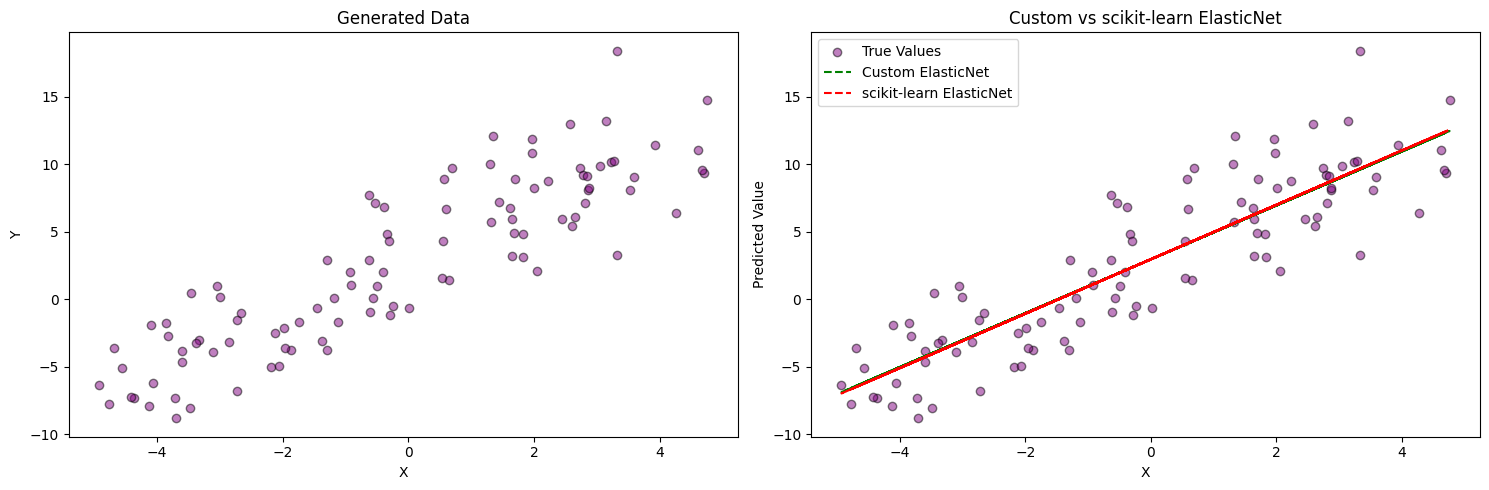

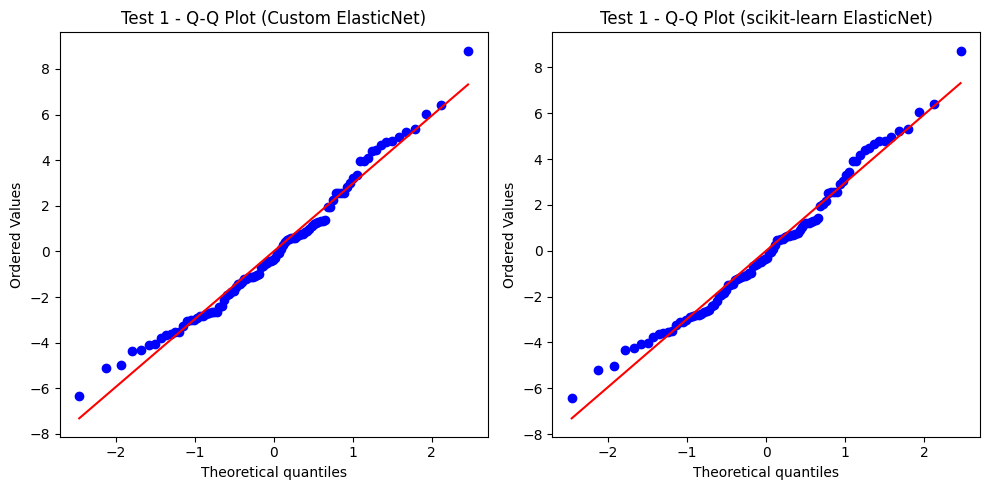

In [5]:
print("TEST1: Linear Data 1 (multiple features)")

# Import ElasticNet from scikit-learn
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# Parameters for the model and data generation
alpha = 0.05
l1_ratio = 0.9
max_iter = 500
tol = 1e-5
learning_rate = 0.05  # Set the learning rate for your custom model
range_ = [-5, 5]
noise_scale = 0.1
N = 100
seed = 42

# Generate linear data with one feature
X, ys = linear_data_generator1(2, 3, range_, N, seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X.reshape(-1, 1), ys)  # Using the custom fit method
y_pred_custom = results_custom.predict(X.reshape(-1, 1))  # Predict with custom class

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X.reshape(-1, 1), ys)
y_pred_sklearn = sklearn_model.predict(X.reshape(-1, 1))

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")


# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Plot the entire generated data
axs[0].scatter(X, ys, color='purple', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Data')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Right plot: Plot the same points and both fitted models
axs[1].scatter(X, ys, label='True Values', color='purple', alpha=0.5, edgecolor='k')
axs[1].plot(X, y_pred_custom, label='Custom ElasticNet', color='green', linestyle='--')
axs[1].plot(X, y_pred_sklearn, label='scikit-learn ElasticNet', color='red', linestyle='--')
axs[1].set_title('Custom vs scikit-learn ElasticNet')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()



# Plot Q-Q plot for Test 1
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 1")

TEST2: Linear Data 2 (2 features)
Custom ElasticNet - R²: 0.9887, MSE: 0.5379
scikit-learn ElasticNet - R²: 0.9993, MSE: 0.0313


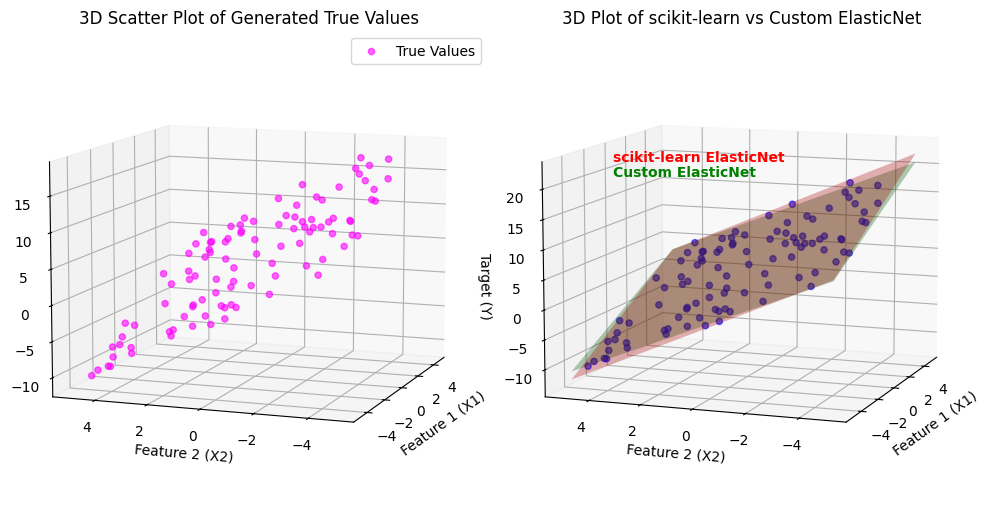

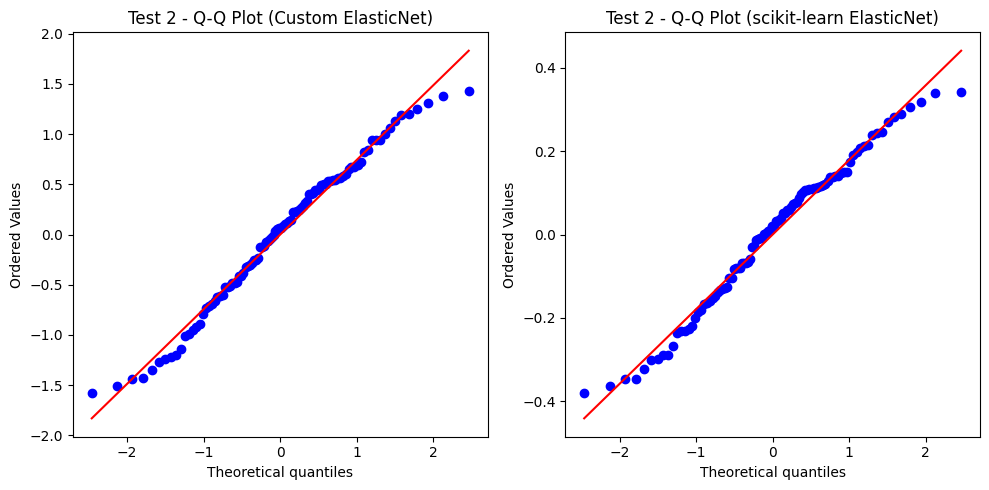

In [6]:
print("TEST2: Linear Data 2 (2 features)")
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting capabilities

# Parameters for the model and data generation
alpha = 0.3
l1_ratio = 0.8
max_iter = 500
tol = 1e-5
learning_rate = 0.05  # Set the learning rate for this test
range_ = [-5, 5]
N = 100
seed = 42
m = np.array([1.5, -2.0])  # Now using only 2 features
b = 5

# Test 2 linear_data_generator2 function (with 2 features)
def linear_data_generator2(m, b, range_, N, seed):
    rng = np.random.default_rng(seed=seed)
    sample = rng.uniform(low=range_[0], high=range_[1], size=(N, m.shape[0]))
    ys = np.dot(sample, np.reshape(m, (-1, 1))) + b
    noise = rng.normal(loc=0., scale=50, size=ys.shape)
    return sample, ys.flatten()

# Generate data with 2 features
X, ys = linear_data_generator2(m, b, range_, N, seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X, ys)  # Use X directly without reshaping
y_pred_custom = results_custom.predict(X)  # Predict with custom class

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")


def plot_with_adjustable_view(elev1=20, azim1=60, elev2=30, azim2=120):
    # Create a figure with two subplots for the 3D plots
    fig = plt.figure(figsize=(10, 8))

    # Plot 1: 3D Scatter plot of the generated true values
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], ys, color='magenta', label='True Values', alpha=0.6)
    ax1.set_title('3D Scatter Plot of Generated True Values')
    ax1.set_xlabel('Feature 1 (X1)')
    ax1.set_ylabel('Feature 2 (X2)')
    ax1.set_zlabel('Target (Y)')
    ax1.legend()

    # Rotate the first plot with adjustable view angles
    ax1.view_init(elev=elev1, azim=azim1)

    # Plot 2: 3D plot comparing scikit-learn's ElasticNet fit and custom ElasticNet fit
    ax2 = fig.add_subplot(122, projection='3d')

    # Plot the true values as scatter points for reference
    ax2.scatter(X[:, 0], X[:, 1], ys, color='blue', label='True Values', alpha=0.6)

    # Plot the scikit-learn ElasticNet surface
    X1_grid, X2_grid = np.meshgrid(np.linspace(range_[0], range_[1], 50), np.linspace(range_[0], range_[1], 50))
    X_grid = np.c_[X1_grid.ravel(), X2_grid.ravel()]
    y_pred_sklearn_grid = sklearn_model.predict(X_grid).reshape(X1_grid.shape)

    ax2.plot_surface(X1_grid, X2_grid, y_pred_sklearn_grid, color='red', alpha=0.3, rstride=100, cstride=100)

    # Plot the custom ElasticNet regression surface
    y_pred_custom_grid = results_custom.predict(X_grid).reshape(X1_grid.shape)  # Call predict from results_custom

    ax2.plot_surface(X1_grid, X2_grid, y_pred_custom_grid, color='green', alpha=0.3, rstride=100, cstride=100)

    # Add labels to the fits
    ax2.text(-1, 5, np.max(y_pred_sklearn_grid), 'scikit-learn ElasticNet', color='red', fontsize=10, weight='bold')
    ax2.text(-1, 5, np.max(y_pred_custom_grid)-1, 'Custom ElasticNet', color='green', fontsize=10, weight='bold')

    # Set labels and title
    ax2.set_title('3D Plot of scikit-learn vs Custom ElasticNet')
    ax2.set_xlabel('Feature 1 (X1)')
    ax2.set_ylabel('Feature 2 (X2)')
    ax2.set_zlabel('Target (Y)')

    # Rotate the second plot with adjustable view angles
    ax2.view_init(elev=elev2, azim=azim2)

    plt.tight_layout()
    plt.show()

# Call the function with customizable angles for both plots
plot_with_adjustable_view(elev1=10, azim1=200, elev2=10, azim2=200)




# Plot Q-Q plot for Test 2
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 2")

TEST3: Nonlinear Data 1
Custom ElasticNet - R²: 0.7089, MSE: 1.8455
scikit-learn ElasticNet - R²: 0.7119, MSE: 1.8267


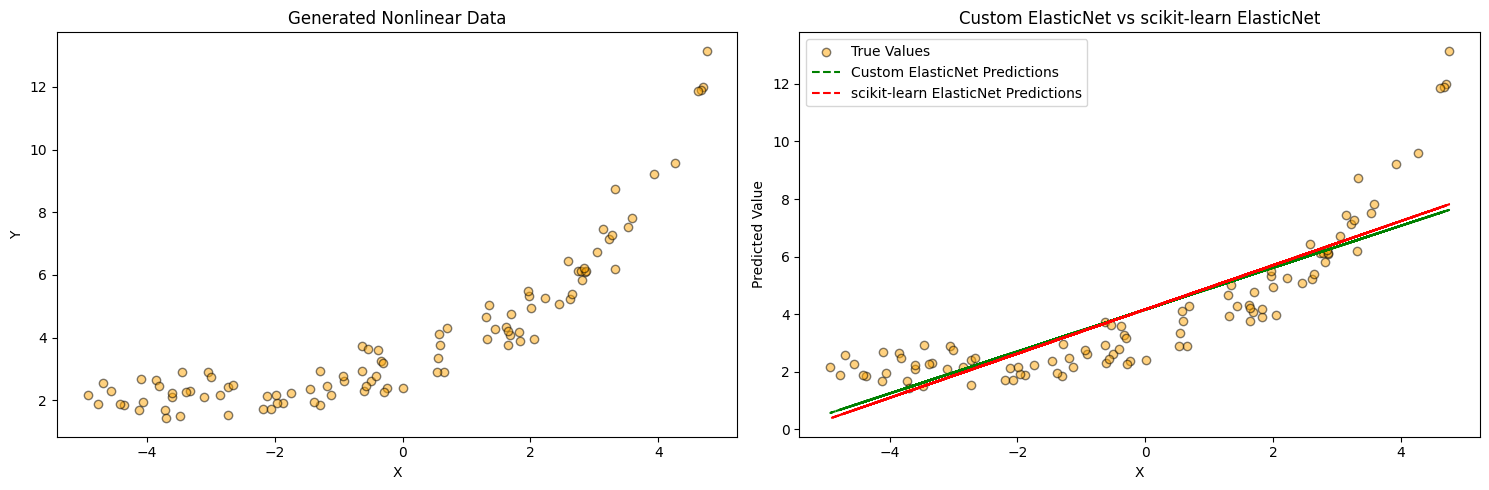

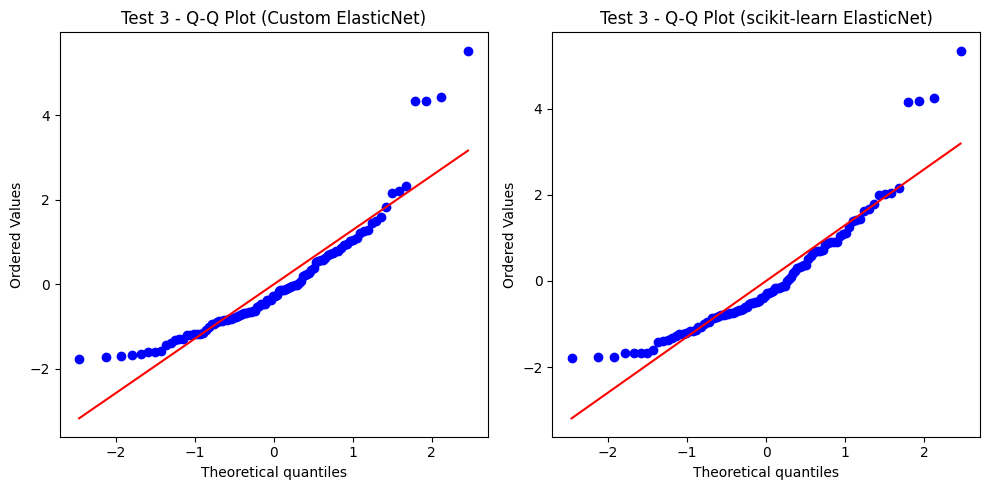

In [7]:
print("TEST3: Nonlinear Data 1")

from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the model and data generation
alpha = 0.1
l1_ratio = 0.7
max_iter = 500
tol = 1e-5
learning_rate = 0.01  # Set the learning rate for this test
range_ = [-5, 5]
N = 100
seed = 42

# Generate nonlinear data
X, ys = nonlinear_data_generator1(0.5, 2, range_, N, seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X.reshape(-1, 1), ys)  # Using the custom fit method
y_pred_custom = results_custom.predict(X.reshape(-1, 1))  # Predict with custom class

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X.reshape(-1, 1), ys)
y_pred_sklearn = sklearn_model.predict(X.reshape(-1, 1))

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Plot the entire generated data
axs[0].scatter(X, ys, color='orange', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Nonlinear Data')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Right plot: Plot the same points with both fitted models
axs[1].scatter(X, ys, label='True Values', color='orange', alpha=0.5, edgecolor='k')
axs[1].plot(X, y_pred_custom, label='Custom ElasticNet Predictions', color='green', linestyle='--')
axs[1].plot(X, y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', linestyle='--')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()



# Plot Q-Q plot for Test 3
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 3")

TEST 4: Collinear Data (Custom ElasticNet vs scikit-learn ElasticNet)
Custom ElasticNet - R²: 0.9999, MSE: 0.0273
scikit-learn ElasticNet - R²: 1.0000, MSE: 0.0077


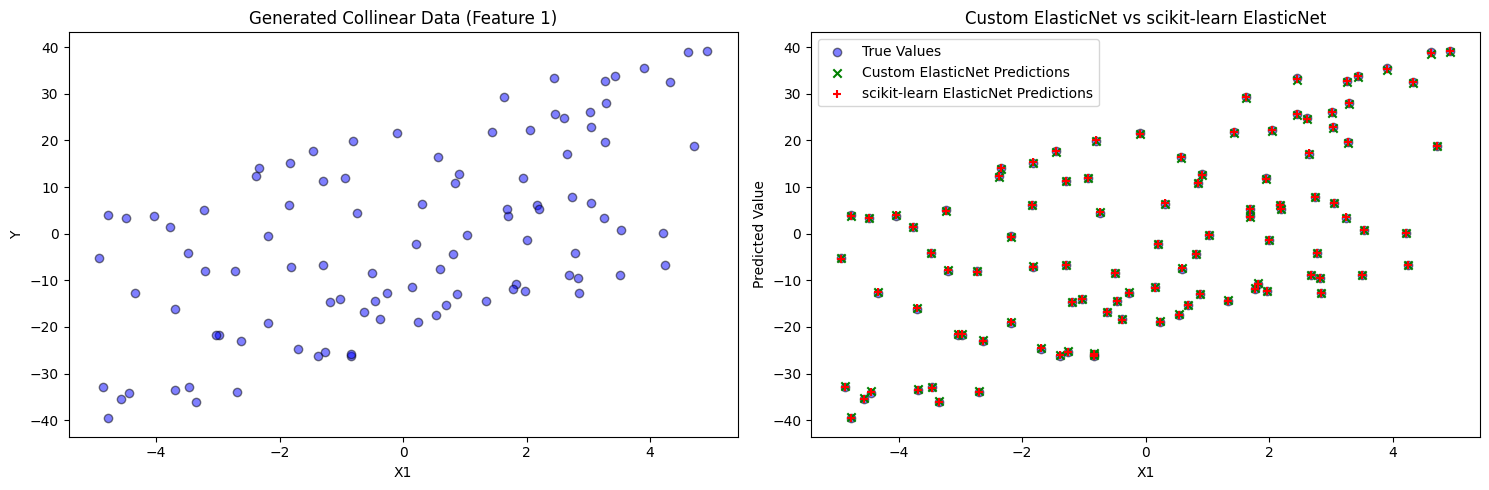

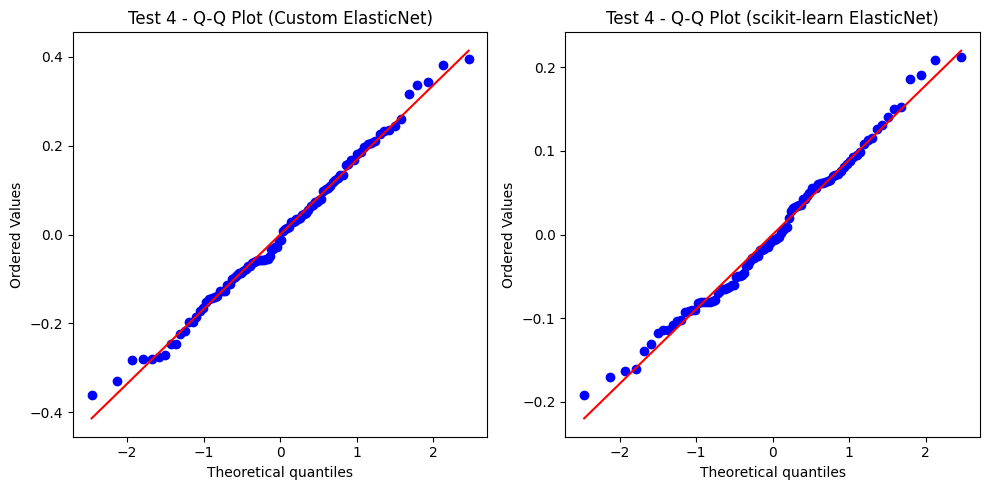

In [8]:
# --- TEST 4: Collinear Data (Custom ElasticNet vs scikit-learn ElasticNet) ---
print("TEST 4: Collinear Data (Custom ElasticNet vs scikit-learn ElasticNet)")

# Parameters for the model and data generation
alpha = 0.05
l1_ratio = 0.9
max_iter = 500
tol = 1e-5
learning_rate = 0.05  # Set the learning rate for this test
range_ = [-5, 5]
noise_scale = 0.01
N = 100
seed = 42

# Generate collinear data
X, ys = generate_collinear_data(range_, noise_scale, (N, 3), seed)

# Instantiate custom MSE and R² calculators
mse_calculator = MyMSE()
rsquared_calculator = MyRSquared()

# Initialize and fit the ElasticNetModel (custom model) on the full data
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X, ys.flatten())
y_pred_custom = results_custom.predict(X)

# Initialize and fit the scikit-learn ElasticNet model
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X, ys.flatten())
y_pred_sklearn = sklearn_model.predict(X)

# Evaluate the models using custom R² and MSE on the entire dataset
r_squared_custom = rsquared_calculator.calculate(ys.flatten(), y_pred_custom)
mse_custom = mse_calculator.calculate(ys.flatten(), y_pred_custom)
r_squared_sklearn = r2_score(ys.flatten(), y_pred_sklearn)
mse_sklearn = mean_squared_error(ys.flatten(), y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first feature of the generated data in the left subplot
axs[0].scatter(X[:, 0], ys, color='blue', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Collinear Data (Feature 1)')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('Y')

# Plot the true values and predictions as scatter points with different markers in the right subplot
axs[1].scatter(X[:, 0], ys, label='True Values', color='blue', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom ElasticNet Predictions', color='green', marker='x')
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', marker='+')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()




# Plot Q-Q plot for Test 4
plot_qq(ys.flatten(), y_pred_custom, y_pred_sklearn, "Test 4")

TEST5: Periodic Data
Custom ElasticNet - R²: 0.0043, MSE: 33.0456
scikit-learn ElasticNet - R²: 0.0088, MSE: 32.8964


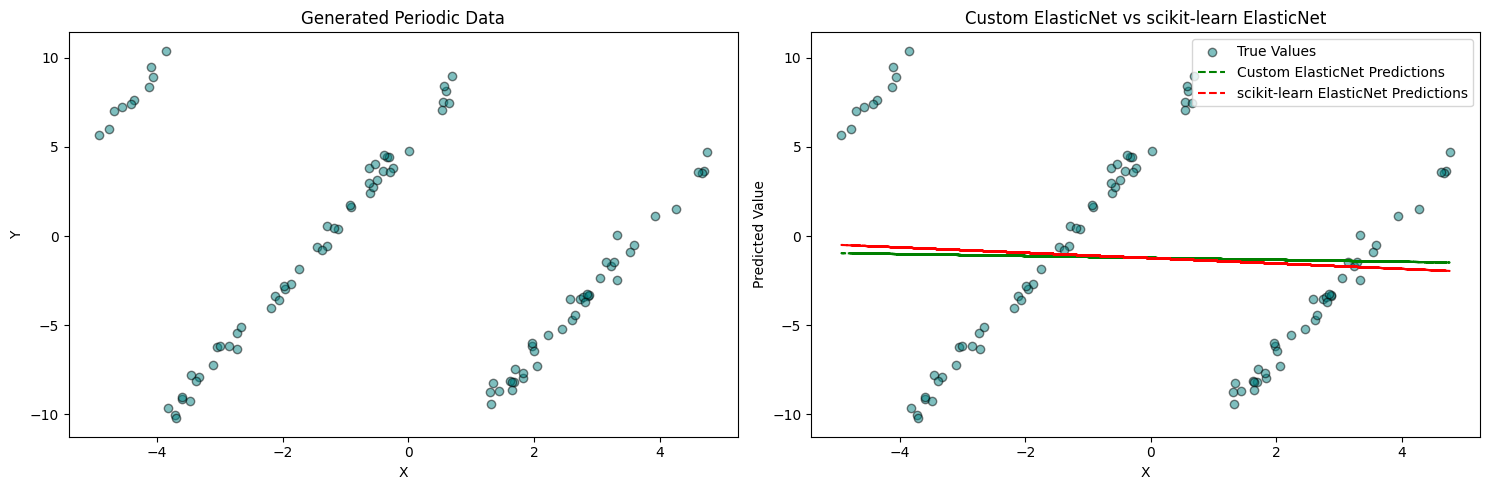

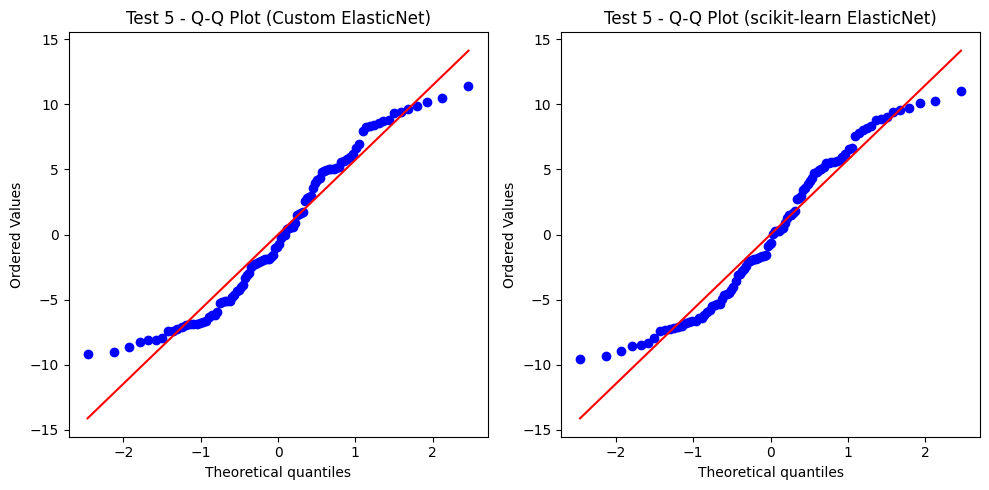

In [9]:
print("TEST5: Periodic Data")

from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the model and data generation
alpha = 0.5
l1_ratio = 0.8
max_iter = 500
tol = 1e-5
learning_rate = 0.01  # Set the learning rate for this test
range_ = [-5, 5]
period = 5
amplitude = 10
noise_scale = 0.5
N = 100
seed = 42

# Generate periodic data
X, ys = generate_periodic_data(period, amplitude, range_, noise_scale, N, seed)

# Reshape the data for fitting into models
X_reshaped = X.reshape(-1, 1)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X.reshape(-1, 1), ys)  # Using the custom fit method
y_pred_custom = results_custom.predict(X.reshape(-1, 1))  # Predict with custom class

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X.reshape(-1, 1), ys)
y_pred_sklearn = sklearn_model.predict(X.reshape(-1, 1))

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left plot: Plot the entire generated data
axs[0].scatter(X, ys, color='teal', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Periodic Data')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Right plot: Plot the same points and both fitted models
axs[1].scatter(X, ys, label='True Values', color='teal', alpha=0.5, edgecolor='k')
axs[1].plot(X, y_pred_custom, label='Custom ElasticNet Predictions', color='green', linestyle='--')
axs[1].plot(X, y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', linestyle='--')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()



# Plot Q-Q plot for Test 5
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 5")

TEST6: Higher Dimensional Data
Custom ElasticNet - R²: 0.8569, MSE: 386.7134
scikit-learn ElasticNet - R²: 0.8786, MSE: 328.2655


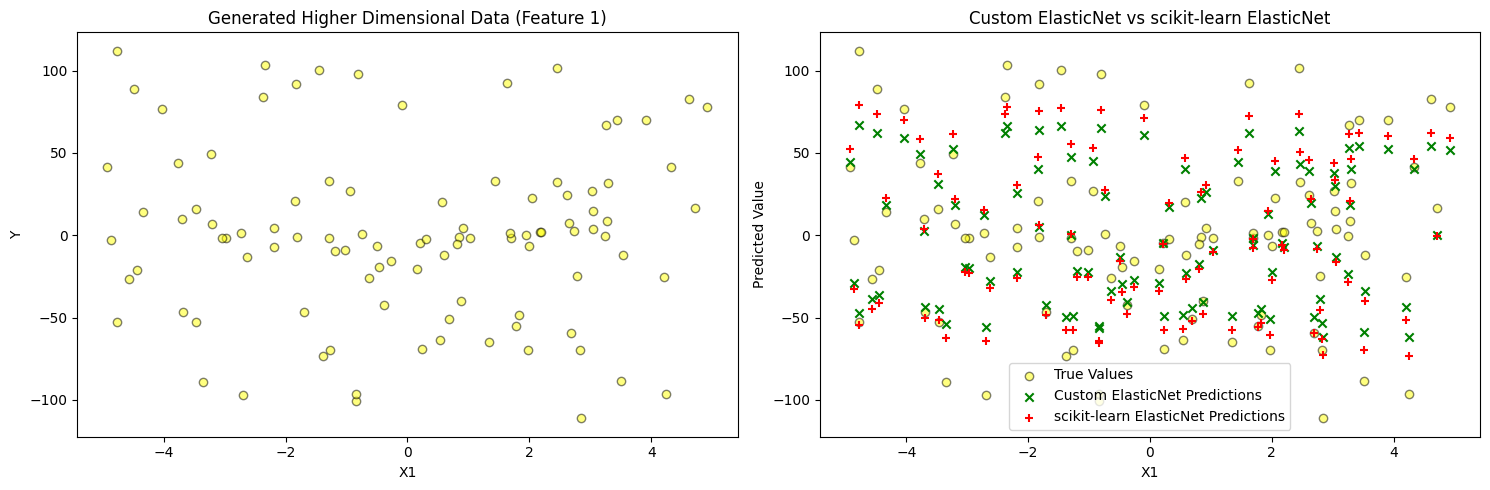

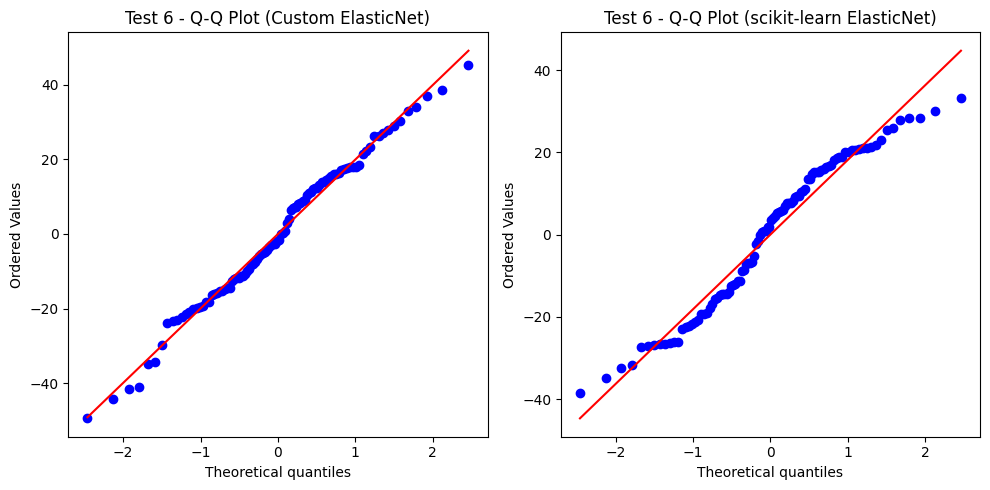

In [10]:
print("TEST6: Higher Dimensional Data")

# Parameters for the model and data generation
alpha = 0.5
l1_ratio = 0.8
max_iter = 500
tol = 1e-5
learning_rate = 0.005  # Set the learning rate for this test
range_ = [-5, 5]
noise_scale = 0.5
N = 100
seed = 42

# Generate higher dimensional data
X, ys = generate_higher_dim_data(range_, noise_scale, (N, 3), seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X, ys)  # Using the custom fit method
y_pred_custom = results_custom.predict(X)  # Predict with custom class

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first feature for visualization in the left subplot
axs[0].scatter(X[:, 0], ys, color='yellow', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Higher Dimensional Data (Feature 1)')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('Y')

# Plot the true values and predictions as scatter points with different markers in the right subplot
axs[1].scatter(X[:, 0], ys, label='True Values', color='yellow', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom ElasticNet Predictions', color='green', marker='x')
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', marker='+')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()




# Plot Q-Q plot for Test 6
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 6")

TEST7: High Collinearity with 50 Variables
Custom ElasticNet - R²: 1.0000, MSE: 0.1678
scikit-learn ElasticNet - R²: 1.0000, MSE: 1.4301


/Users/harleeliz/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+04, tolerance: 4.658e+02
  model = cd_fast.enet_coordinate_descent(


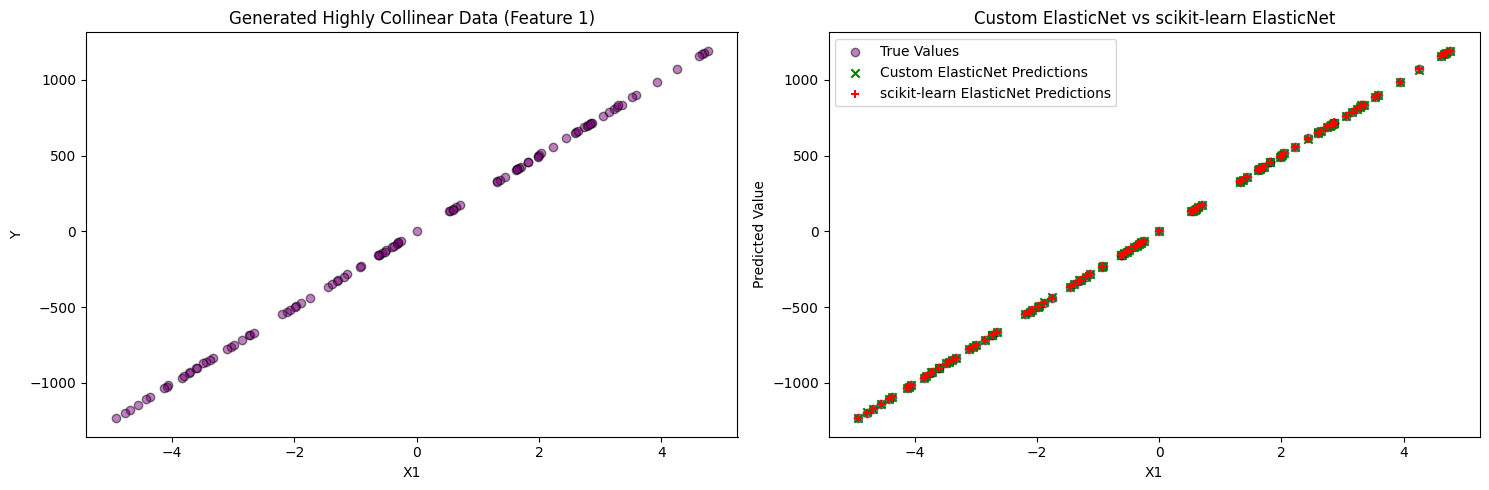

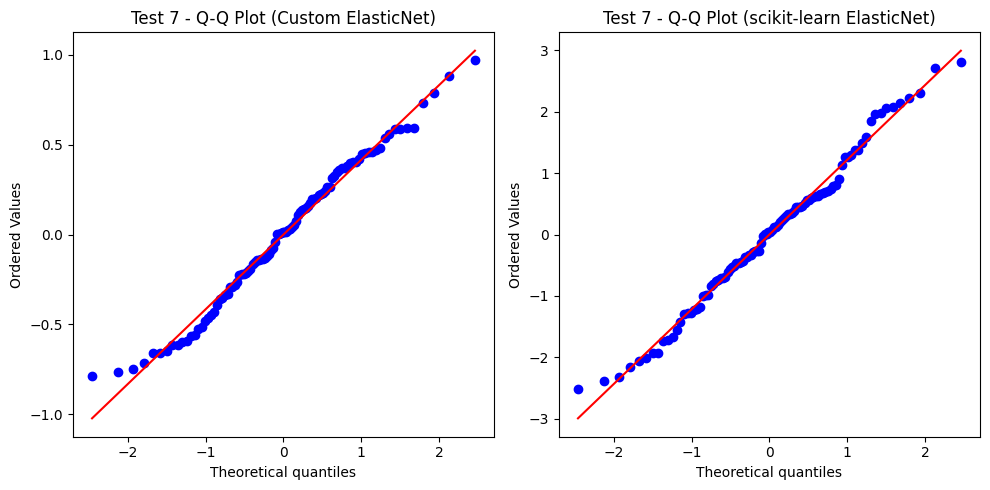

In [11]:
print("TEST7: High Collinearity with 50 Variables")

import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Function to generate highly collinear data with many variables
def generate_high_collinear_data(n_features, size, seed):
    rng = np.random.default_rng(seed=seed)

    # Base feature
    base = rng.uniform(low=-5, high=5, size=size)

    # Create many features that are highly correlated with the base feature
    collinear_data = np.array([base + rng.normal(0, 0.01, size) for _ in range(n_features)]).T

    # Generate the target using a linear combination of the features
    coefficients = rng.uniform(low=1, high=10, size=n_features)
    ys = collinear_data @ coefficients + rng.normal(0, 0.1, size)

    return collinear_data, ys

# Parameters for the model and data generation
alpha = 0.1
l1_ratio = 0.8
max_iter = 500
tol = 1e-5
learning_rate = 0.01
n_features = 50  # Now we're using 50 highly collinear features
N = 100
seed = 42

# Generate highly collinear data
X, ys = generate_high_collinear_data(n_features, N, seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X, ys)
y_pred_custom = results_custom.predict(X)

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first feature for visualization in the left subplot
axs[0].scatter(X[:, 0], ys, color='purple', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Highly Collinear Data (Feature 1)')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('Y')

# Plot the true values and predictions as scatter points with different markers in the right subplot
axs[1].scatter(X[:, 0], ys, label='True Values', color='purple', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom ElasticNet Predictions', color='green', marker='x')
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', marker='+')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 7
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 7")


TEST8: Extreme Scenario with Sparsity, Collinearity, and Noise


/Users/harleeliz/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+05, tolerance: 6.921e+02
  model = cd_fast.enet_coordinate_descent(


Custom ElasticNet - R²: 0.9998, MSE: 146.1757
scikit-learn ElasticNet - R²: 0.9999, MSE: 70.7380


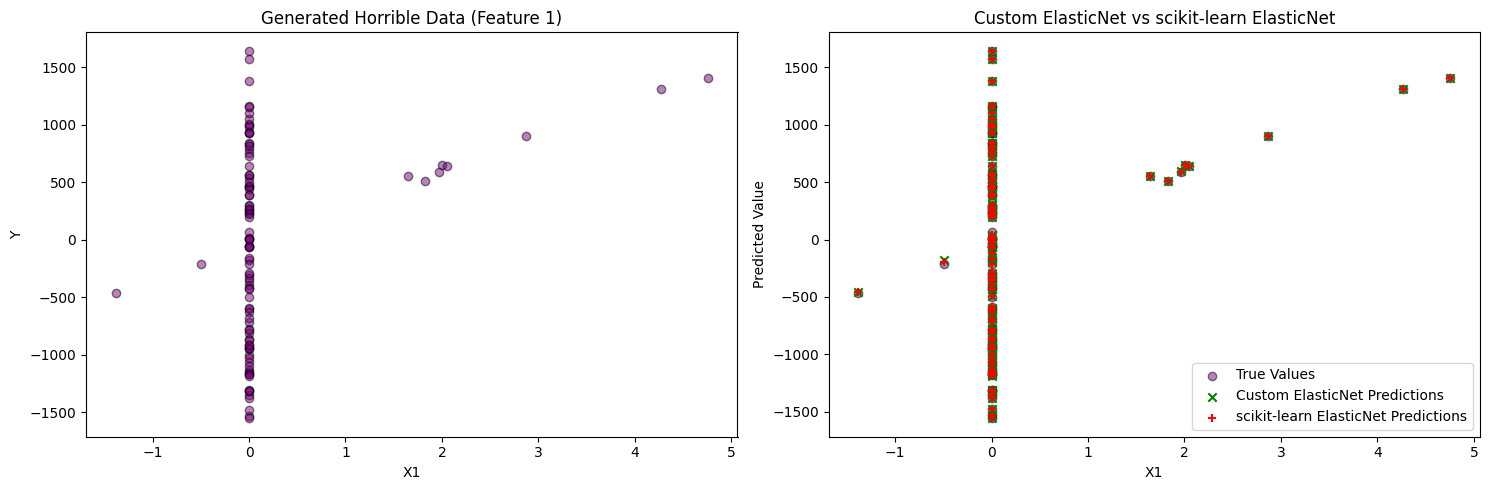

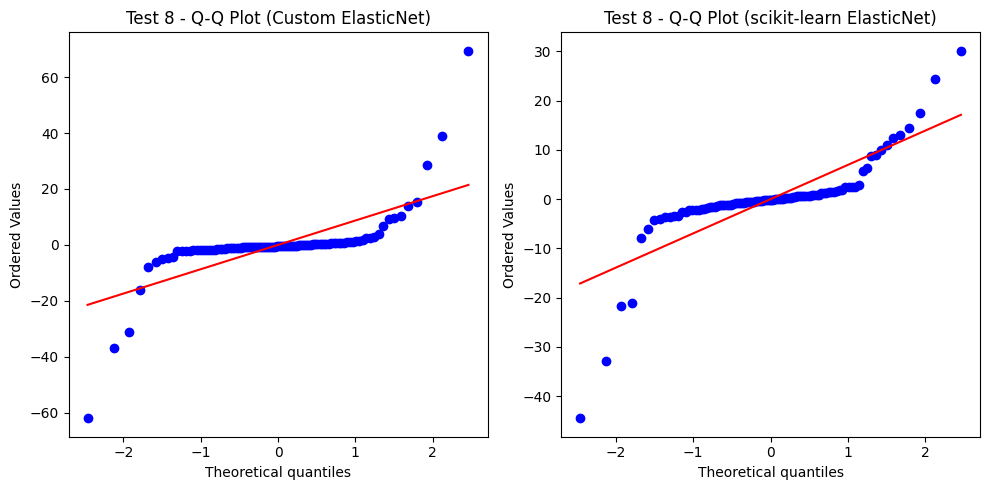

In [12]:
print("TEST8: Extreme Scenario with Sparsity, Collinearity, and Noise")

import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Function to generate horrible scenario data with high sparsity, collinearity, and noise
def generate_horrible_data(n_features, size, seed):
    rng = np.random.default_rng(seed=seed)

    # Base feature
    base = rng.uniform(low=-5, high=5, size=size)

    # Create a lot of collinear features
    collinear_data = np.array([base + rng.normal(0, 0.001, size) for _ in range(n_features)]).T

    # Add high sparsity (features with very low values)
    sparsity_mask = rng.choice([0, 1], size=collinear_data.shape, p=[0.9, 0.1])  # 90% of the data is zeros
    collinear_data = collinear_data * sparsity_mask

    # Generate the target with extreme noise
    coefficients = rng.uniform(low=1, high=5, size=n_features)
    ys = collinear_data @ coefficients + rng.normal(0, 100, size)  # Huge noise added

    return collinear_data, ys

# Parameters for the model and data generation
alpha = 0.1
l1_ratio = 0.8
max_iter = 500
tol = 1e-5
learning_rate = 0.01
n_features = 1000  # Use 1000 features (crazy high dimensionality)
N = 100  # Fewer observations compared to features
seed = 42

# Generate horrible data
X, ys = generate_horrible_data(n_features, N, seed)

# Initialize and fit your custom ElasticNet model
custom_model = ElasticNetModel(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol, learning_rate=learning_rate)
results_custom = custom_model.fit(X, ys)
y_pred_custom = results_custom.predict(X)

# Initialize and fit the scikit-learn ElasticNet model for comparison
sklearn_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, tol=tol)
sklearn_model.fit(X, ys)
y_pred_sklearn = sklearn_model.predict(X)

# Use custom R-squared and MSE for evaluation
r_squared_custom = MyRSquared().calculate(ys, y_pred_custom)
mse_custom = MyMSE().calculate(ys, y_pred_custom)
r_squared_sklearn = r2_score(ys, y_pred_sklearn)
mse_sklearn = mean_squared_error(ys, y_pred_sklearn)

# Print comparison results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"scikit-learn ElasticNet - R²: {r_squared_sklearn:.4f}, MSE: {mse_sklearn:.4f}")

# Create a figure with two subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first feature for visualization in the left subplot
axs[0].scatter(X[:, 0], ys, color='purple', alpha=0.5, edgecolor='k')
axs[0].set_title('Generated Horrible Data (Feature 1)')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('Y')

# Plot the true values and predictions as scatter points with different markers in the right subplot
axs[1].scatter(X[:, 0], ys, label='True Values', color='purple', alpha=0.5, edgecolor='k')
axs[1].scatter(X[:, 0], y_pred_custom, label='Custom ElasticNet Predictions', color='green', marker='x')
axs[1].scatter(X[:, 0], y_pred_sklearn, label='scikit-learn ElasticNet Predictions', color='red', marker='+')
axs[1].set_title('Custom ElasticNet vs scikit-learn ElasticNet')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('Predicted Value')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plot Q-Q plot for Test 8
plot_qq(ys, y_pred_custom, y_pred_sklearn, "Test 8")